In [25]:
import pandas as pd
import numpy as np
import xgboost as xgb
import os
import matplotlib.pyplot as plt

from math import sqrt
import datetime
import pickle

import sklearn
from sklearn.model_selection import ParameterGrid
from sklearn.metrics import mean_squared_error

In [26]:
%matplotlib inline

# Load the preprocessed data

In [27]:
# Get the pre-processed data:
#X = pickle.load(open('../data/fs_data_lags_1_12.pkl', 'rb'))
X = pickle.load(open('../data/fs_data_lags_1_to_6.pkl', 'rb'))

In [28]:
# convenient to be able to refer to target and predictor values like this
target_var = 'item_cnt_month'
predictor_cols = [col for col in X.columns.tolist() if col not in [target_var, 'ID', 'item_name', 'shop_name',
                                                                   'date_block_num','item_category_name']]


# Create test and validation sets

In [29]:
# Instead of creating separate train and validation data sets, we'll just partition the main set, 
# splitting based on time to match the way the test set works
train_rows      = np.where(X['date_block_num'] <= 32)[0]
validation_rows = np.where(X['date_block_num'] == 33)[0]
test_rows       = np.where(X['date_block_num'] == 34)[0]


In [30]:
# xgboost doesn't like data frames
xgtrain = xgb.DMatrix(X.iloc[train_rows][predictor_cols].values,      
                      label=X.iloc[train_rows][target_var].values,     
                      feature_names=predictor_cols)

xgval   = xgb.DMatrix(X.iloc[validation_rows][predictor_cols].values, 
                      label=X.iloc[validation_rows][target_var].values, 
                      feature_names=predictor_cols)

xgtest  = xgb.DMatrix(X.iloc[test_rows][predictor_cols].values, 
                      label=X.iloc[test_rows][target_var].values,
                      feature_names=predictor_cols)



In [31]:
# other parameters
num_round = 5000
watchlist = [(xgtrain, 'train'),(xgval, 'eval')] # early stopping uses the last one listed here

# Grid search for parameters

In [13]:
# parameter tuning
params_grid = {
    'objective':['reg:linear'], 
    'eval_metric':['rmse'], 
    'min_child_weight' : [1,10,100],
    'max_depth':[4,6,8], 
    'eta': [0.01, 0.1],    #  learning rate, try [2-10] / nrounds
    'gamma': [0.05, .5, 1, 10],   # min_split_loss
    'subsample' : [0.6, 0.8, 1.0],
    'colsample_bytree':[0.8, 0.9, 1],
    'alpha' : [0.1],
    'silent': [0]
}



In [ ]:
# fit a model with each combination of parameters in the grid
best_rmse  = float("Inf")
best_params = None
best_model = None

for params in ParameterGrid(params_grid):

    # fit a model with the selected parameters
    model = xgb.train(params, 
                      xgtrain,
                      num_round, 
                      watchlist, 
                      early_stopping_rounds=10)
    
    # evaluate the model
    preds  = model.predict(xgval, ntree_limit=model.best_iteration)

    # clip to 0-20 to match test data
    preds = np.clip(preds, 0, 20)

    # compare to the (similarly clipped) validation data
    rmse = sqrt(mean_squared_error(preds, np.clip(X.iloc[validation_rows][target_var].values, 0, 20)))
    
    # if we beat the current best rmse, record the model
    if rmse < best_rmse:
        best_params = params
        best_rmse   = rmse
        best_model  = model 
    
    print("Best rmse so far is", best_rmse, 'with params', best_params)   
    


[0]	train-rmse:1.5076	eval-rmse:1.41115
Multiple eval metrics have been passed: 'eval-rmse' will be used for early stopping.

Will train until eval-rmse hasn't improved in 10 rounds.
[1]	train-rmse:1.50112	eval-rmse:1.4062
[2]	train-rmse:1.49501	eval-rmse:1.40159
[3]	train-rmse:1.48879	eval-rmse:1.39675
[4]	train-rmse:1.48282	eval-rmse:1.3922
[5]	train-rmse:1.47676	eval-rmse:1.38754
[6]	train-rmse:1.47075	eval-rmse:1.38282
[7]	train-rmse:1.4649	eval-rmse:1.37829
[8]	train-rmse:1.45961	eval-rmse:1.37439
[9]	train-rmse:1.45389	eval-rmse:1.37012
[10]	train-rmse:1.44824	eval-rmse:1.3658
[11]	train-rmse:1.44298	eval-rmse:1.36198
[12]	train-rmse:1.43746	eval-rmse:1.35776
[13]	train-rmse:1.43219	eval-rmse:1.35382
[14]	train-rmse:1.42739	eval-rmse:1.35011
[15]	train-rmse:1.42264	eval-rmse:1.34662
[16]	train-rmse:1.41782	eval-rmse:1.34283
[17]	train-rmse:1.41271	eval-rmse:1.33893
[18]	train-rmse:1.40785	eval-rmse:1.3353
[19]	train-rmse:1.40324	eval-rmse:1.33174
[20]	train-rmse:1.39832	eval-rmse

[191]	train-rmse:1.10004	eval-rmse:1.1241
[192]	train-rmse:1.09966	eval-rmse:1.12393
[193]	train-rmse:1.09926	eval-rmse:1.12376
[194]	train-rmse:1.09884	eval-rmse:1.12362
[195]	train-rmse:1.09841	eval-rmse:1.12345
[196]	train-rmse:1.09806	eval-rmse:1.12329
[197]	train-rmse:1.09758	eval-rmse:1.123
[198]	train-rmse:1.09715	eval-rmse:1.12272
[199]	train-rmse:1.0967	eval-rmse:1.12249
[200]	train-rmse:1.09626	eval-rmse:1.1223
[201]	train-rmse:1.09573	eval-rmse:1.12198
[202]	train-rmse:1.09526	eval-rmse:1.12175
[203]	train-rmse:1.09476	eval-rmse:1.12146
[204]	train-rmse:1.09434	eval-rmse:1.12129
[205]	train-rmse:1.09398	eval-rmse:1.12116
[206]	train-rmse:1.09361	eval-rmse:1.12099
[207]	train-rmse:1.09318	eval-rmse:1.12072
[208]	train-rmse:1.09268	eval-rmse:1.12038
[209]	train-rmse:1.09226	eval-rmse:1.12012
[210]	train-rmse:1.09193	eval-rmse:1.11996
[211]	train-rmse:1.09152	eval-rmse:1.11977
[212]	train-rmse:1.0912	eval-rmse:1.11959
[213]	train-rmse:1.09082	eval-rmse:1.11942
[214]	train-rmse:

[383]	train-rmse:1.05502	eval-rmse:1.10555
[384]	train-rmse:1.05489	eval-rmse:1.10551
[385]	train-rmse:1.05476	eval-rmse:1.10547
[386]	train-rmse:1.05466	eval-rmse:1.10544
[387]	train-rmse:1.05456	eval-rmse:1.10543
[388]	train-rmse:1.05449	eval-rmse:1.10538
[389]	train-rmse:1.05436	eval-rmse:1.10534
[390]	train-rmse:1.05426	eval-rmse:1.1053
[391]	train-rmse:1.05411	eval-rmse:1.10522
[392]	train-rmse:1.05404	eval-rmse:1.10523
[393]	train-rmse:1.05395	eval-rmse:1.10521
[394]	train-rmse:1.05388	eval-rmse:1.1052
[395]	train-rmse:1.05372	eval-rmse:1.10514
[396]	train-rmse:1.05364	eval-rmse:1.10513
[397]	train-rmse:1.05357	eval-rmse:1.1051
[398]	train-rmse:1.05346	eval-rmse:1.10503
[399]	train-rmse:1.05331	eval-rmse:1.10493
[400]	train-rmse:1.05318	eval-rmse:1.10484
[401]	train-rmse:1.05307	eval-rmse:1.1048
[402]	train-rmse:1.05291	eval-rmse:1.10469
[403]	train-rmse:1.0528	eval-rmse:1.10464
[404]	train-rmse:1.05261	eval-rmse:1.10451
[405]	train-rmse:1.05246	eval-rmse:1.1045
[406]	train-rmse:

[575]	train-rmse:1.03871	eval-rmse:1.09998
[576]	train-rmse:1.03867	eval-rmse:1.09997
[577]	train-rmse:1.03862	eval-rmse:1.09996
[578]	train-rmse:1.03854	eval-rmse:1.09996
[579]	train-rmse:1.03849	eval-rmse:1.09995
[580]	train-rmse:1.03844	eval-rmse:1.09994
[581]	train-rmse:1.03836	eval-rmse:1.09992
[582]	train-rmse:1.03829	eval-rmse:1.0999
[583]	train-rmse:1.03825	eval-rmse:1.09989
[584]	train-rmse:1.03821	eval-rmse:1.0999
[585]	train-rmse:1.03819	eval-rmse:1.09989
[586]	train-rmse:1.03814	eval-rmse:1.09987
[587]	train-rmse:1.0381	eval-rmse:1.09985
[588]	train-rmse:1.03804	eval-rmse:1.09984
[589]	train-rmse:1.038	eval-rmse:1.09981
[590]	train-rmse:1.0379	eval-rmse:1.09979
[591]	train-rmse:1.03787	eval-rmse:1.09978
[592]	train-rmse:1.03783	eval-rmse:1.09978
[593]	train-rmse:1.03777	eval-rmse:1.09979
[594]	train-rmse:1.03771	eval-rmse:1.09979
[595]	train-rmse:1.03769	eval-rmse:1.09979
[596]	train-rmse:1.0376	eval-rmse:1.09979
[597]	train-rmse:1.03754	eval-rmse:1.09976
[598]	train-rmse:1

[767]	train-rmse:1.02838	eval-rmse:1.09742
[768]	train-rmse:1.02833	eval-rmse:1.09744
[769]	train-rmse:1.02821	eval-rmse:1.09738
[770]	train-rmse:1.02817	eval-rmse:1.09735
[771]	train-rmse:1.02812	eval-rmse:1.09732
[772]	train-rmse:1.02805	eval-rmse:1.09726
[773]	train-rmse:1.02801	eval-rmse:1.09726
[774]	train-rmse:1.02799	eval-rmse:1.09726
[775]	train-rmse:1.02794	eval-rmse:1.09723
[776]	train-rmse:1.02788	eval-rmse:1.09717
[777]	train-rmse:1.02778	eval-rmse:1.09709
[778]	train-rmse:1.02775	eval-rmse:1.09707
[779]	train-rmse:1.02769	eval-rmse:1.09705
[780]	train-rmse:1.02765	eval-rmse:1.09705
[781]	train-rmse:1.02761	eval-rmse:1.09704
[782]	train-rmse:1.02757	eval-rmse:1.09703
[783]	train-rmse:1.02754	eval-rmse:1.09703
[784]	train-rmse:1.02748	eval-rmse:1.09702
[785]	train-rmse:1.02742	eval-rmse:1.09701
[786]	train-rmse:1.02738	eval-rmse:1.09701
[787]	train-rmse:1.02734	eval-rmse:1.09699
[788]	train-rmse:1.0273	eval-rmse:1.09698
[789]	train-rmse:1.02728	eval-rmse:1.09699
[790]	train-

[959]	train-rmse:1.0196	eval-rmse:1.09455
[960]	train-rmse:1.01958	eval-rmse:1.09457
[961]	train-rmse:1.01956	eval-rmse:1.09457
[962]	train-rmse:1.01954	eval-rmse:1.09457
[963]	train-rmse:1.01948	eval-rmse:1.09456
[964]	train-rmse:1.01947	eval-rmse:1.09457
[965]	train-rmse:1.01941	eval-rmse:1.09455
[966]	train-rmse:1.01937	eval-rmse:1.09453
[967]	train-rmse:1.0193	eval-rmse:1.0945
[968]	train-rmse:1.01928	eval-rmse:1.09449
[969]	train-rmse:1.01926	eval-rmse:1.09449
[970]	train-rmse:1.01921	eval-rmse:1.09448
[971]	train-rmse:1.01916	eval-rmse:1.09449
[972]	train-rmse:1.01911	eval-rmse:1.09449
[973]	train-rmse:1.01906	eval-rmse:1.09443
[974]	train-rmse:1.019	eval-rmse:1.09444
[975]	train-rmse:1.01897	eval-rmse:1.09443
[976]	train-rmse:1.01894	eval-rmse:1.09441
[977]	train-rmse:1.01891	eval-rmse:1.09443
[978]	train-rmse:1.01888	eval-rmse:1.09442
[979]	train-rmse:1.01886	eval-rmse:1.09441
[980]	train-rmse:1.01881	eval-rmse:1.09442
[981]	train-rmse:1.01877	eval-rmse:1.09441
[982]	train-rmse

[69]	train-rmse:1.23377	eval-rmse:1.21009
[70]	train-rmse:1.23147	eval-rmse:1.20856
[71]	train-rmse:1.22919	eval-rmse:1.20696
[72]	train-rmse:1.22711	eval-rmse:1.20571
[73]	train-rmse:1.22508	eval-rmse:1.20438
[74]	train-rmse:1.223	eval-rmse:1.20306
[75]	train-rmse:1.22091	eval-rmse:1.20159
[76]	train-rmse:1.21874	eval-rmse:1.20021
[77]	train-rmse:1.21672	eval-rmse:1.19898
[78]	train-rmse:1.21474	eval-rmse:1.19769
[79]	train-rmse:1.21281	eval-rmse:1.1965
[80]	train-rmse:1.21094	eval-rmse:1.19528
[81]	train-rmse:1.20898	eval-rmse:1.19393
[82]	train-rmse:1.20714	eval-rmse:1.19273
[83]	train-rmse:1.20522	eval-rmse:1.19142
[84]	train-rmse:1.20338	eval-rmse:1.19012
[85]	train-rmse:1.20156	eval-rmse:1.18897
[86]	train-rmse:1.19976	eval-rmse:1.18778
[87]	train-rmse:1.19799	eval-rmse:1.18653
[88]	train-rmse:1.19625	eval-rmse:1.18553
[89]	train-rmse:1.19453	eval-rmse:1.18446
[90]	train-rmse:1.19266	eval-rmse:1.183
[91]	train-rmse:1.19101	eval-rmse:1.18191
[92]	train-rmse:1.18952	eval-rmse:1.180

# (alternatively: quick check for a single set of parameters)

In [32]:
# best xgboost parameters I found
params = {'alpha': 1, 'colsample_bytree': 0.8, 'eta': 0.01, 'eval_metric': 'rmse', 'gamma': 0, 'max_depth': 8, 'min_child_weight': 100, 'objective': 'reg:linear', 'silent': 0, 'subsample': 0.8}



In [33]:
best_model = xgb.train(params, 
                  xgtrain,
                  num_round, 
                  watchlist, 
                  early_stopping_rounds=10)

[0]	train-rmse:1.50754	eval-rmse:1.41111
Multiple eval metrics have been passed: 'eval-rmse' will be used for early stopping.

Will train until eval-rmse hasn't improved in 10 rounds.
[1]	train-rmse:1.50118	eval-rmse:1.40616
[2]	train-rmse:1.49478	eval-rmse:1.4012
[3]	train-rmse:1.48847	eval-rmse:1.39626
[4]	train-rmse:1.48247	eval-rmse:1.39172
[5]	train-rmse:1.4763	eval-rmse:1.38691
[6]	train-rmse:1.47026	eval-rmse:1.38216
[7]	train-rmse:1.46431	eval-rmse:1.37759
[8]	train-rmse:1.4584	eval-rmse:1.37299
[9]	train-rmse:1.4527	eval-rmse:1.36867
[10]	train-rmse:1.44723	eval-rmse:1.3645
[11]	train-rmse:1.44165	eval-rmse:1.36027
[12]	train-rmse:1.43615	eval-rmse:1.35597
[13]	train-rmse:1.43075	eval-rmse:1.352
[14]	train-rmse:1.42536	eval-rmse:1.34797
[15]	train-rmse:1.4202	eval-rmse:1.34391
[16]	train-rmse:1.41527	eval-rmse:1.34033
[17]	train-rmse:1.41016	eval-rmse:1.33644
[18]	train-rmse:1.40521	eval-rmse:1.3327
[19]	train-rmse:1.4005	eval-rmse:1.3292
[20]	train-rmse:1.39574	eval-rmse:1.32

[192]	train-rmse:1.09971	eval-rmse:1.12386
[193]	train-rmse:1.09925	eval-rmse:1.12365
[194]	train-rmse:1.09884	eval-rmse:1.12348
[195]	train-rmse:1.09845	eval-rmse:1.12328
[196]	train-rmse:1.09799	eval-rmse:1.12306
[197]	train-rmse:1.09755	eval-rmse:1.12291
[198]	train-rmse:1.09712	eval-rmse:1.12267
[199]	train-rmse:1.09669	eval-rmse:1.12244
[200]	train-rmse:1.09631	eval-rmse:1.12224
[201]	train-rmse:1.0959	eval-rmse:1.12204
[202]	train-rmse:1.09558	eval-rmse:1.12189
[203]	train-rmse:1.09517	eval-rmse:1.12174
[204]	train-rmse:1.0947	eval-rmse:1.12152
[205]	train-rmse:1.09432	eval-rmse:1.12136
[206]	train-rmse:1.09395	eval-rmse:1.12118
[207]	train-rmse:1.09356	eval-rmse:1.12105
[208]	train-rmse:1.09319	eval-rmse:1.12085
[209]	train-rmse:1.09282	eval-rmse:1.1207
[210]	train-rmse:1.09236	eval-rmse:1.12041
[211]	train-rmse:1.09204	eval-rmse:1.12024
[212]	train-rmse:1.09173	eval-rmse:1.12008
[213]	train-rmse:1.09144	eval-rmse:1.11999
[214]	train-rmse:1.09111	eval-rmse:1.1199
[215]	train-rms

[384]	train-rmse:1.05681	eval-rmse:1.10666
[385]	train-rmse:1.05668	eval-rmse:1.10659
[386]	train-rmse:1.05656	eval-rmse:1.10655
[387]	train-rmse:1.05644	eval-rmse:1.10651
[388]	train-rmse:1.05633	eval-rmse:1.1065
[389]	train-rmse:1.05624	eval-rmse:1.10648
[390]	train-rmse:1.05616	eval-rmse:1.10648
[391]	train-rmse:1.05602	eval-rmse:1.10641
[392]	train-rmse:1.05586	eval-rmse:1.1063
[393]	train-rmse:1.05578	eval-rmse:1.10628
[394]	train-rmse:1.0557	eval-rmse:1.10625
[395]	train-rmse:1.05559	eval-rmse:1.10621
[396]	train-rmse:1.05552	eval-rmse:1.10617
[397]	train-rmse:1.05541	eval-rmse:1.10614
[398]	train-rmse:1.05529	eval-rmse:1.1061
[399]	train-rmse:1.05511	eval-rmse:1.106
[400]	train-rmse:1.05505	eval-rmse:1.10598
[401]	train-rmse:1.05491	eval-rmse:1.10593
[402]	train-rmse:1.05484	eval-rmse:1.1059
[403]	train-rmse:1.05472	eval-rmse:1.10587
[404]	train-rmse:1.05464	eval-rmse:1.10586
[405]	train-rmse:1.05448	eval-rmse:1.10574
[406]	train-rmse:1.05438	eval-rmse:1.10571
[407]	train-rmse:1

[576]	train-rmse:1.04126	eval-rmse:1.1017
[577]	train-rmse:1.04121	eval-rmse:1.1017
[578]	train-rmse:1.04118	eval-rmse:1.10172
[579]	train-rmse:1.0411	eval-rmse:1.1017
[580]	train-rmse:1.04103	eval-rmse:1.10169
[581]	train-rmse:1.041	eval-rmse:1.10168
[582]	train-rmse:1.04092	eval-rmse:1.10167
[583]	train-rmse:1.04087	eval-rmse:1.10166
[584]	train-rmse:1.04079	eval-rmse:1.10159
[585]	train-rmse:1.04067	eval-rmse:1.10157
[586]	train-rmse:1.04062	eval-rmse:1.10151
[587]	train-rmse:1.04056	eval-rmse:1.10152
[588]	train-rmse:1.04053	eval-rmse:1.10151
[589]	train-rmse:1.0405	eval-rmse:1.10151
[590]	train-rmse:1.04042	eval-rmse:1.10149
[591]	train-rmse:1.0403	eval-rmse:1.10147
[592]	train-rmse:1.0402	eval-rmse:1.10147
[593]	train-rmse:1.04014	eval-rmse:1.10145
[594]	train-rmse:1.04008	eval-rmse:1.10142
[595]	train-rmse:1.04001	eval-rmse:1.10139
[596]	train-rmse:1.03994	eval-rmse:1.10137
[597]	train-rmse:1.03986	eval-rmse:1.1013
[598]	train-rmse:1.03981	eval-rmse:1.1013
[599]	train-rmse:1.039

[768]	train-rmse:1.0296	eval-rmse:1.09837
[769]	train-rmse:1.02952	eval-rmse:1.09838
[770]	train-rmse:1.02941	eval-rmse:1.09839
[771]	train-rmse:1.02939	eval-rmse:1.09838
[772]	train-rmse:1.02931	eval-rmse:1.09837
[773]	train-rmse:1.02927	eval-rmse:1.09835
[774]	train-rmse:1.02918	eval-rmse:1.09832
[775]	train-rmse:1.02914	eval-rmse:1.09831
[776]	train-rmse:1.02913	eval-rmse:1.0983
[777]	train-rmse:1.02907	eval-rmse:1.09823
[778]	train-rmse:1.02905	eval-rmse:1.09823
[779]	train-rmse:1.02901	eval-rmse:1.09823
[780]	train-rmse:1.02897	eval-rmse:1.09823
[781]	train-rmse:1.02893	eval-rmse:1.0982
[782]	train-rmse:1.02891	eval-rmse:1.09818
[783]	train-rmse:1.02886	eval-rmse:1.09816
[784]	train-rmse:1.02883	eval-rmse:1.09816
[785]	train-rmse:1.02878	eval-rmse:1.09817
[786]	train-rmse:1.02876	eval-rmse:1.09817
[787]	train-rmse:1.02859	eval-rmse:1.09811
[788]	train-rmse:1.02854	eval-rmse:1.09807
[789]	train-rmse:1.02848	eval-rmse:1.09806
[790]	train-rmse:1.02843	eval-rmse:1.09804
[791]	train-rm

[960]	train-rmse:1.02026	eval-rmse:1.0956
[961]	train-rmse:1.02021	eval-rmse:1.09557
[962]	train-rmse:1.02016	eval-rmse:1.09556
[963]	train-rmse:1.02009	eval-rmse:1.09552
[964]	train-rmse:1.02005	eval-rmse:1.09548
[965]	train-rmse:1.02002	eval-rmse:1.09547
[966]	train-rmse:1.01993	eval-rmse:1.0954
[967]	train-rmse:1.01988	eval-rmse:1.09542
[968]	train-rmse:1.01985	eval-rmse:1.09543
[969]	train-rmse:1.01981	eval-rmse:1.09543
[970]	train-rmse:1.01974	eval-rmse:1.0954
[971]	train-rmse:1.01971	eval-rmse:1.09539
[972]	train-rmse:1.01968	eval-rmse:1.09539
[973]	train-rmse:1.01961	eval-rmse:1.09538
[974]	train-rmse:1.01954	eval-rmse:1.09536
[975]	train-rmse:1.01952	eval-rmse:1.09535
[976]	train-rmse:1.01943	eval-rmse:1.09535
[977]	train-rmse:1.01939	eval-rmse:1.09532
[978]	train-rmse:1.01934	eval-rmse:1.09532
[979]	train-rmse:1.01931	eval-rmse:1.09532
[980]	train-rmse:1.01924	eval-rmse:1.09528
[981]	train-rmse:1.01911	eval-rmse:1.09521
[982]	train-rmse:1.0191	eval-rmse:1.09519
[983]	train-rms

In [34]:
# Evaluate
preds  = best_model.predict(xgval, ntree_limit=best_model.best_iteration)

# clip to 0-20 to match test data
preds = np.clip(preds, 0, 20)

# compare to the (similarly clipped) validation data
# sqrt(mean_squared_error(preds, X.iloc[validation_rows][target_var].values))
rmse = sqrt(mean_squared_error(preds, np.clip(X.iloc[validation_rows][target_var].values, 0, 20)))
rmse

0.9041374794373264

# Inspect the model

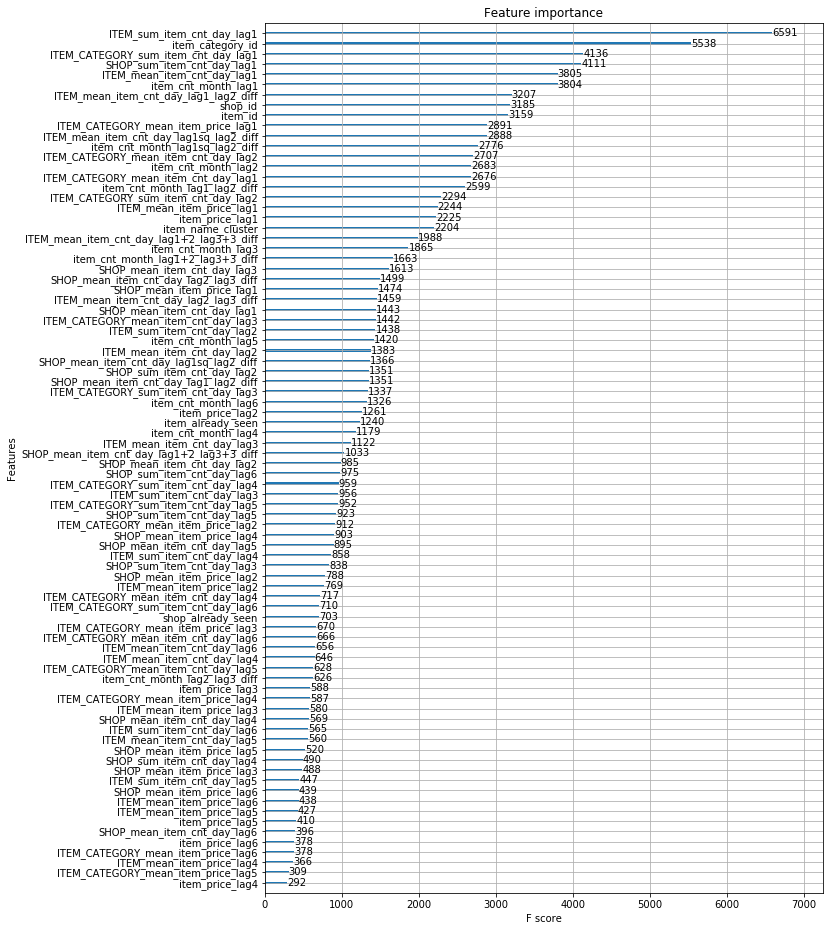

In [35]:
# inspect the variables used in the model
plt.rcParams['figure.figsize'] = [10,16]
xgb.plot_importance(best_model)


In [36]:
# Save the model
#pickle.dump(fs_xgb, open('fs_xgb_lags_1_12_up_to_month_33.pkl', 'wb'))
#pickle.dump(fs_xgb, open('fs_xgb_lags_1_to_6_up_to_month_33.pkl', 'wb'))

In [ ]:
# save the predictions
#pickle.dump(preds, open('fs_xgb_lags_1_12_preds_up_to_month_33.pkl', 'wb'))
pickle.dump(preds, open('fs_xgb_lags_1_to_6_preds_up_to_month_33.pkl', 'wb'))

# Refit with all the data

In [ ]:
# fit on all the data
train_rows_full = np.where(X['date_block_num'] <= 33)[0]

xgtrain_full = xgb.DMatrix(X.iloc[train_rows_full][predictor_cols].values, 
                           label=X.iloc[train_rows_full][target_var].values, 
                           feature_names=predictor_cols)

watchlist = [(xgtrain_full, 'train')] 

fs_xgb = xgb.train(params, xgtrain_full, best_model.best_iteration, watchlist)  





[0]	train-rmse:1.50512
[1]	train-rmse:1.49871
[2]	train-rmse:1.49243
[3]	train-rmse:1.48642
[4]	train-rmse:1.48025
[5]	train-rmse:1.47426
[6]	train-rmse:1.46826
[7]	train-rmse:1.46253
[8]	train-rmse:1.45668
[9]	train-rmse:1.45092
[10]	train-rmse:1.44524
[11]	train-rmse:1.43966
[12]	train-rmse:1.43424
[13]	train-rmse:1.42908
[14]	train-rmse:1.42374
[15]	train-rmse:1.41878
[16]	train-rmse:1.41359
[17]	train-rmse:1.40851
[18]	train-rmse:1.40348
[19]	train-rmse:1.39857
[20]	train-rmse:1.39367
[21]	train-rmse:1.38901
[22]	train-rmse:1.38431
[23]	train-rmse:1.37949
[24]	train-rmse:1.37495
[25]	train-rmse:1.37053
[26]	train-rmse:1.36606
[27]	train-rmse:1.36168
[28]	train-rmse:1.35736
[29]	train-rmse:1.3531
[30]	train-rmse:1.349
[31]	train-rmse:1.34493
[32]	train-rmse:1.34097
[33]	train-rmse:1.33699
[34]	train-rmse:1.33318
[35]	train-rmse:1.32955
[36]	train-rmse:1.3257
[37]	train-rmse:1.32194
[38]	train-rmse:1.31846
[39]	train-rmse:1.31478
[40]	train-rmse:1.3112
[41]	train-rmse:1.30796
[42]	tr

In [ ]:
# make predictions for the test set
preds = fs_xgb.predict(xgtest, ntree_limit=best_model.best_iteration)  
preds = np.clip(preds, 0, 20)

In [ ]:
# Save the model
#pickle.dump(fs_xgb, open('fs_xgb_lags_1_12_up_to_month_34.pkl', 'wb'))
#pickle.dump(fs_xgb, open('fs_xgb_lags_1_to_6_up_to_month_34.pkl', 'wb'))

In [ ]:
# save the predictions
#pickle.dump(preds, open('fs_xgb_lags_1_12_preds_up_to_month_34.pkl', 'wb'))
pickle.dump(preds, open('fs_xgb_lags_1_to_6_preds_up_to_month_34.pkl', 'wb'))

# Submission

In [18]:
# create submission file
submission_filename = 'future_sales_' + datetime.datetime.now().strftime("%Y%m%d_%H%M%S") + '.csv'

submission = pd.DataFrame({
  'ID' : [int(x) for x in X.iloc[test_rows].ID],
  'item_cnt_month' : preds
 })

# make sure this is in the same order as the test data
submission = submission.sort_values('ID')

submission.to_csv('../submissions/' + submission_filename,index=False)